In [1]:
import os
from tqdm import tqdm_notebook as tqdm
import numpy as np

from phathom import io
from phathom.phenotype import celltype
from phathom.utils import extract_box, insert_box

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
working_dir = '/media/jswaney/Drive/Justin/coregistration/gabi_pv'

In [4]:
pv_path = 'pvtdtomato_zarrstack/1_1_1'
syto_path = 'syto16_zarrstack/1_1_1'

pv_img = io.zarr.open(os.path.join(working_dir, pv_path))
syto_img = io.zarr.open(os.path.join(working_dir, syto_path))

pv_img.shape, syto_img.shape

((256, 7275, 5529), (256, 7275, 5529))

In [5]:
print(dir(celltype))

['AgglomerativeClustering', 'NearestNeighbors', 'Voronoi', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_detect_nuclei_chunk', 'calculate_eigvals', 'calculate_mfi', 'calculate_stdev', 'cluster', 'cluster_dendrogram', 'cm', 'connectivity', 'convex_seeds', 'curvature_probability', 'dendrogram', 'detect_nuclei_parallel', 'eigvals_of_weingarten', 'expit', 'filtering', 'find_centroids', 'gaussian', 'griddata', 'intensity_probability', 'kneighbors_graph', 'linkage', 'local_densities', 'mcolors', 'morphology', 'multiprocessing', 'ndi', 'negative_curvature_product', 'np', 'nuclei_centered_intensities', 'nuclei_centers_ncp', 'nuclei_centers_probability', 'nuclei_centers_probability2', 'nucleus_probability', 'partial', 'peak_local_max', 'plt', 'query_neighbors', 'query_radius', 'rasterize_regions', 'sample_intensity_cube', 'seed_probability', 'sigmoid', 'skimage', 'smooth', 'threshold_mfi', 'tqdm', 'utils', 'voronoi', 'voronoi_plot', 

In [6]:
prob_img = io.zarr.new_zarr(os.path.join(working_dir, 'pv_probability.zarr'), pv_img.shape, pv_img.chunks, dtype=np.float32)

In [15]:
pv_test_img = pv_img[:128, 2000:2128, 2000:2128]
pv_test_img.shape

(128, 128, 128)

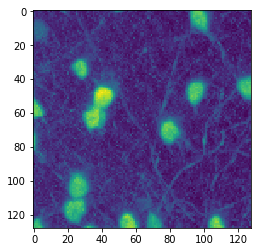

In [16]:
plt.figure()
plt.imshow(pv_test_img.max(axis=0))
plt.show()

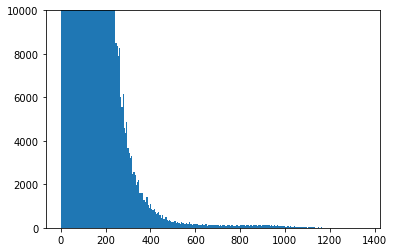

In [34]:
plt.hist(pv_test_img.ravel(), bins=256)
plt.ylim([0, 10000])
plt.show()

0.9652793911905247


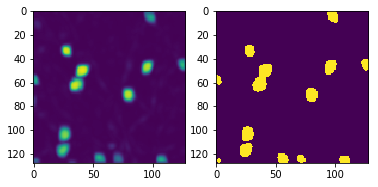

In [30]:
sigma = (2.0, 3.5, 3.5)
steepness = 20000
offset = 0.0001

prob_test = celltype.nucleus_probability(pv_test_img, sigma, steepness, offset)

print(prob_test.max())
plt.subplot(121)
plt.imshow(prob_test.max(axis=0), clim=[0, 1])
plt.subplot(122)
plt.imshow(prob_test.max(axis=0) > 0.2, clim=[0, 1])
plt.show()

In [35]:
prob_thresh = 0.2
min_intensity = 200
min_dist = 3
chunks = (128, 128, 128)
overlap = 16

centers = celltype.detect_nuclei_parallel(pv_img, 
                                          sigma, 
                                          min_intensity, 
                                          steepness, 
                                          offset, 
                                          prob_thresh, 
                                          min_dist, 
                                          chunks, 
                                          overlap, 
                                          prob_output=prob_img)

100%|██████████| 5016/5016 [1:27:19<00:00,  1.04s/it]


In [42]:
n = 0
for c in centers:
    if c is not None:
        n += c.shape[0]
print(n)

101718


In [43]:
centers_list = [c for c in centers if c is not None]
len(centers_list)

2232

In [45]:
pts = np.vstack(centers_list)
pts.shape

(101718, 3)

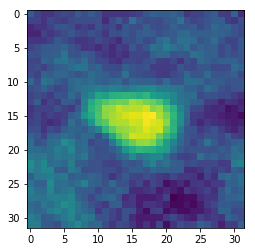

In [56]:
p = pts[10000]

height = 8
width = 32

start = p - np.array([height//2, width//2, width//2])
stop = start + np.array([height, width, width])

pv_box = extract_box(pv_img, start, stop)

plt.imshow(pv_box.max(axis=0))
plt.show()

In [57]:
np.save(os.path.join(working_dir, 'pv_pts.npy'), pts)

In [58]:
from tqdm import tqdm_notebook as tqdm

In [59]:
patches = []
for p in tqdm(pts, total=pts.shape[0]):
    start = p - np.array([height//2, width//2, width//2])
    stop = start + np.array([height, width, width])
    pv_box = extract_box(pv_img, start, stop)
    if pv_box.shape != (8, 32, 32):
        continue
    pv_patch = pv_box.max(axis=0)
    patches.append(pv_patch)


In [60]:
len(patches)

101163

In [63]:
pv_patches = np.empty((len(patches), *patches[0].shape), patches[0].dtype)

In [64]:
for i, p in enumerate(patches):
    pv_patches[i] = p

In [65]:
pv_patches.shape

(101163, 32, 32)

In [66]:
np.save(os.path.join(working_dir, 'pv_patches.npy'), pv_patches)

In [67]:
from sklearn.decomposition import PCA

In [68]:
X = pv_patches.reshape(pv_patches.shape[0], np.prod(pv_patches.shape[1:]))
X.shape

(101163, 1024)

In [86]:
pca = PCA(n_components=1)
pca.fit(X)
print(pca.explained_variance_ratio_)  

[0.60545453]


In [87]:
Z = pca.transform(X)
Z.shape

(101163, 1)

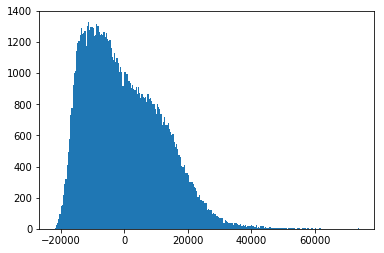

In [88]:
# plt.plot(Z[:, 0], Z[:, 1], 'bo', alpha=0.01)
plt.hist(Z[:, 0], bins=256)
plt.show()

In [89]:
idx = Z[:, 0].argsort()
pv_patch_sorted = pv_patches[idx]

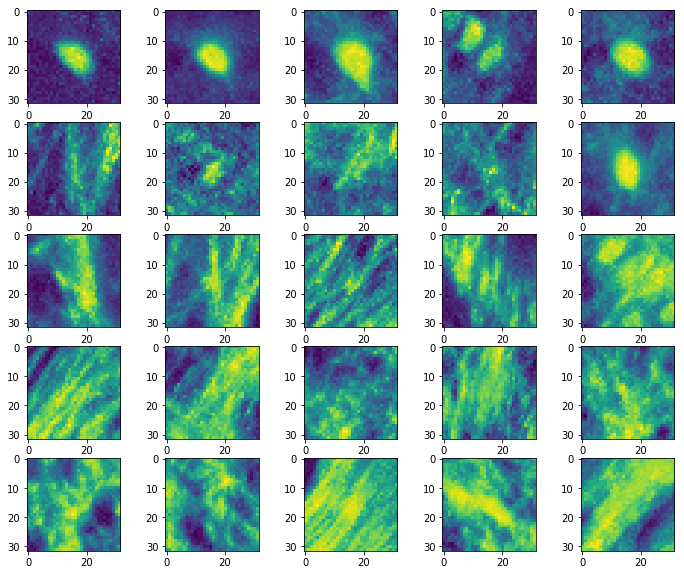

In [110]:
samples = np.arange(3, pv_patch_sorted.shape[0], 4200)

n = len(samples)
ncols = 5
nrows = n // ncols + 1

plt.figure(figsize=(12, 12))
for i, s in enumerate(samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(pv_patch_sorted[s])
plt.show()

PCA could be used to more quickly generate labeled data by clicking on blocks in a sorted array like this. We could also train a denoising autoencoder and then try the same thing, the hope being that the features will be more discriminative. 

In a semi-supervised setting using a generative model, a variational autoencoder could be used to get a decent encoding as well but with a different objective (reconstruction + KL divergence for posterior approximation). It's not clear if simple gaussian priors can model such a diverse set of visual features in the false positive patches, but we could turn to normalizing flows or auxillary latent variables if we need more flexibility.

In Kingma 2014, three models were tested: a VAE + TSVM classifer, a combination of generative VAE and MLP-based descrimintor, a double-stochastic trained embedding using a combination of these two. The last model was by far the best performing one (maybe due to more expressive power?). Even the best model started with a VAE, so we should first check the embedding that we get from that. From there we can decide if we want to build the more complex model. The VAE doesn't actually make use of the labeled data, so it might not do a great job separating out the false positives.

Also, the image patches don't need to be 2D, so we have a decision to make there. Of course 2D patches are the least expensive option, but we need to check if the final accuracy is good enough. If not, we may need to use 3D information at the risk of making training a lot harder. We already have some baseline results using PCA and InceptionV3 on 2D patches, so we should work from there and try to improve.

- Train VAE on 2D patches
- Compare the VAE embedding to PCA
- Create a small, balanced set of labeled patches (~100 in each class)
- Train a DGM on top of the pretrained VAE using labels (M1+M2)
- Compare the M1+M2 embedding to VAE and PCA